# CNS Ab initio Project

This project is designed to study complex molecular properties using machine learning algorithm.
The developer used the example of CNS penatrating propability to demonstrate the feasibility of the methodogy and the algorithm. 
Yigao Yuan, 04/29/19.

## preparations, package import and data pre-process

In [1]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)


1.12.0


In [3]:
import pandas as pd
cns_df = pd.read_pickle('../../CNS_pMPO.df.pkl')
colum_names=['ALogP98','CNS','Drug','HBA','HBD','MW','SMILES','TPSA','TPSA_S','cLogD_ACD_v15','cLogP_ACD_v15',
                'cLogP_Biobyte','fsp3','mapKa','mbpKa','nArom','nAtoms']
print (cns_df.shape)
dataset = cns_df.copy() 
#clear the data, find out NA first.
print (dataset.isna().sum())
(dataset.head())

(665, 17)
ALogP98            0
CNS                0
Drug               0
HBA                0
HBD                0
MW                 0
SMILES             0
TPSA               0
TPSA_S             0
cLogD_ACD_v15      2
cLogP_ACD_v15      1
cLogP_Biobyte      0
fsp3               0
mapKa            505
mbpKa            247
nArom              0
nAtoms             0
dtype: int64


,ALogP98,CNS,Drug,HBA,HBD,MW,SMILES,TPSA,TPSA_S,cLogD_ACD_v15,cLogP_ACD_v15,cLogP_Biobyte,fsp3,mapKa,mbpKa,nArom,nAtoms
0,0.630,False,Abacavir,6.0,3.0,286.33231,c1nc2c(nc(nc2n1C3CC(C=C3)CO)N)NC4CC4,101.880000,101.88000,0.72,0.72,0.81,0.50,NaN,6.53,2.0,21.0
1,2.119,False,Acetohexamide,4.0,2.0,324.39529,CC(=O)c1ccc(cc1)S(=O)(=O)NC(=O)NC2CCCCC2,92.339996,100.72000,0.46,2.44,2.25,0.47,4.3,NaN,1.0,22.0
2,3.480,False,Acetyldigitoxin,14.0,4.0,806.97577,CC1C(C(CC(O1)OC2C(OC(CC2O)OC3C(OC(CC3O)OC4CCC5...,188.899990,188.89999,3.10,3.10,3.46,0.91,NaN,NaN,0.0,57.0
3,4.601,False,Acrivastine,4.0,1.0,348.43817,Cc1ccc(cc1)/C(=C\CN2CCCC2)/c3cccc(n3)/C=C/C(=O)O,53.430000,53.43000,2.03,4.55,1.46,0.27,NaN,8.88,2.0,26.0
4,-1.423,False,Acyclovir,7.0,3.0,225.20464,c1nc2c(n1COCCO)[nH]c(nc2=O)N,114.760000,114.76000,-1.76,-1.76,-2.60,0.38,NaN,3.15,1.0,16.0


In [76]:
# sort the data by names
dataset = dataset.sort_values(by=['Drug'])
#print(dataset.head())
labels = dataset.pop('CNS')
dataset['CNS'] = (labels>0.5)*1.0

datasetB = dataset.loc[:,['CNS','Drug','SMILES']]
#datasetB.head()
train_dataset = datasetB.sample(frac=0.8,random_state=0)
test_dataset  = datasetB.drop(train_dataset.index)
train_dataset.info()
train_dataset.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 532 entries, 481 to 60
Data columns (total 3 columns):
CNS       532 non-null float64
Drug      532 non-null object
SMILES    532 non-null object
dtypes: float64(1), object(2)
memory usage: 16.6+ KB


,CNS,Drug,SMILES
481,1.0,Flurazepam,CCN(CC)CCN1c2ccc(cc2C(=NCC1=O)c3ccccc3F)Cl
512,1.0,Levopropoxyphene,CCC(=O)OC(Cc1ccccc1)(c2ccccc2)C(C)CN(C)C
6,0.0,Albuterol,CC(C)(C)NCC(c1ccc(c(c1)CO)O)O
571,1.0,Paroxetine,c1cc(ccc1C2CCNCC2COc3ccc4c(c3)OCO4)F
44,0.0,Bethanechol,CC(C[N+](C)(C)C)OC(=O)N


'Flurazepam'

In [5]:
train_labels = train_dataset.pop('CNS')
test_labels  = test_dataset.pop('CNS')
fp_train_labels = np.array(train_labels.iloc[:])
#fp_train_labels = np.array(list(map(lambda x: int(x), train_labels)))
fp_test_labels = np.array(test_labels.iloc[:])
print(type(fp_train_labels))

<class 'numpy.ndarray'>


In [6]:
#fp_train_labels

# fingerprint

In [7]:
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem.rdmolops import RDKFingerprint

# read in the molecules in the form of SMILES,
mols_train = list(map(lambda x: Chem.MolFromSmiles(x) , train_dataset.loc[:,'SMILES']))
mols_test = list(map(lambda x: Chem.MolFromSmiles(x) , test_dataset.loc[:,'SMILES']))
# convert the SMILES into Daylight-type fingerprint
fps_train = list(map(lambda x: RDKFingerprint(x,fpSize=2048) ,mols_train))
fps_test = list(map(lambda x: RDKFingerprint(x,fpSize=2048) ,mols_test))

# convert the Fingerprint to vector
def fp_to_vec(fp):
    fp_str = fp.ToBitString()
    a = list(map(lambda x: int(x), list(fp_str)))
    return np.array(a)

#fp_train_dataset = np.array(list(map(fp_to_vec, fps_train)))
#fp_test_dataset = np.array(list(map(fp_to_vec, fps_test)))



# Descriptors


In [13]:
import numpy as np
from rdkit.Chem import Descriptors
def descriptors_map(mol1):
    
    descriptors_count = 45
    aa = np.zeros(descriptors_count)
    bb = []
    aa[0] = Descriptors.TPSA(mol1)          # TPSA
    bb.append('TPSA')
    aa[1] = Descriptors.MolMR(mol1)      # HBD
    bb.append('Mol MR')
    aa[2] = Descriptors.MolWt(mol1)           # MW
    bb.append('molecular weight')
    aa[3] = Descriptors.MolLogP(mol1)         # Log P
    bb.append('log P')
    aa[4] = Descriptors.HeavyAtomCount(mol1)
    bb.append('num heavy atom')
    aa[5] = Descriptors.FpDensityMorgan1(mol1)
    bb.append('Fp Density Morgan 1')
    aa[6] = Descriptors.FpDensityMorgan2(mol1)
    bb.append('Fp Density Morgan 2')
    aa[7] = Descriptors.FpDensityMorgan3(mol1)
    bb.append('Fp Density Morgan 3')

# H-
    aa[8] = Descriptors.HeavyAtomMolWt(mol1)
    bb.append('Heavy Atom weight')
# M-
    aa[9] = Descriptors.MaxAbsEStateIndex(mol1)
    bb.append('max Abs EState Index')
    aa[10] = Descriptors.MaxAbsPartialCharge(mol1)
    bb.append('max Abs PartialCharge')
    aa[11] = Descriptors.MaxEStateIndex(mol1)
    bb.append('max EState Index')
    aa[12] = Descriptors.MaxPartialCharge(mol1)
    bb.append('max PartialCharge')
    aa[13] = Descriptors.MinAbsEStateIndex(mol1)
    bb.append('min Abs EState Index')
    aa[14] = Descriptors.MinAbsPartialCharge(mol1)
    bb.append('min Abs PartialCharge')
    aa[15] = Descriptors.MinEStateIndex(mol1)
    bb.append('min EState Index')
    aa[16] = Descriptors.MinPartialCharge(mol1)
    bb.append('min PartialCharge')
   
    aa[17] = Descriptors.NumRadicalElectrons(mol1)
    bb.append('num radical etron')
    aa[18] = Descriptors.NumValenceElectrons(mol1)
    bb.append('num valence etron')
    aa[19] = Descriptors.NumHDonors(mol1)
    bb.append('num HB donor')
    aa[20] = Descriptors.NumHAcceptors(mol1)
    bb.append('num HB acceptor')

    aa[21] = Descriptors.BalabanJ(mol1)      # Chem. Phys. Lett. 89:399-404 (1982)
    bb.append('balaban J')
    aa[22] = Descriptors.BertzCT(mol1)       # J. Am. Chem. Soc. 103:3599-601 (1981)
    bb.append('BertzCT')
    aa[23] = Descriptors.Ipc(mol1)           # J. Chem. Phys. 67:4517-33 (1977)
    bb.append('Ipc')
    aa[24] = Descriptors.HallKierAlpha(mol1) # Rev. Comput. Chem. 2:367-422 (1991)
    bb.append('Hall Kier Alpha')
    aa[25] = Descriptors.Kappa1(mol1)        # Rev. Comput. Chem. 2:367-422 (1991)
    bb.append('kappa 1')
    aa[26] = Descriptors.Kappa2(mol1) 
    bb.append('kappa 2')
    aa[27] = Descriptors.Kappa3(mol1)
    bb.append('kappa 3')
    aa[28] = Descriptors.Chi0(mol1)          # Rev. Comput. Chem. 2:367-422 (1991)
    bb.append('chi 0')
    aa[29] = Descriptors.Chi1(mol1)
    bb.append('chi 1')
    aa[30] = Descriptors.Chi0n(mol1)         # Rev. Comput. Chem. 2:367-422 (1991)
    bb.append('chi 0n')
    aa[31] = Descriptors.Chi1n(mol1)
    bb.append('chi 1n')
    aa[32] = Descriptors.Chi2n(mol1)
    bb.append('chi 2n')
    aa[33] = Descriptors.Chi3n(mol1)
    bb.append('chi 3n')
    aa[34] = Descriptors.Chi4n(mol1)
    bb.append('chi 4n')
    
    aa[35] = Descriptors.Chi0v(mol1)
    bb.append('chi 0v')
    aa[36] = Descriptors.Chi1v(mol1)
    bb.append('chi 1v')
    aa[37] = Descriptors.Chi2v(mol1)
    bb.append('chi 2v')
    aa[38] = Descriptors.Chi3v(mol1)
    bb.append('chi 3v')
    aa[39] = Descriptors.Chi4v(mol1)
    bb.append('chi 4v')
    aa[40] = Descriptors.NumRotatableBonds(mol1)
    bb.append('num rotatable bonds')
    aa[41] = Descriptors.NumHeteroatoms(mol1)
    bb.append('num heteroAtoms')
    aa[42] = Descriptors.NumAromaticRings(mol1)
    bb.append('num Aromatic rings')
    aa[43] = Descriptors.FractionCSP3(mol1)
    bb.append('Frac CSP3')
    aa[44] = Descriptors.LabuteASA(mol1)
    bb.append('labute ASA')
    
    return aa

In [12]:
fps_train[0]
bb = descriptors_map(mols_train[0])
(bb)

['TPSA',
 'Mol MR',
 'molecular weight',
 'log P',
 'num heavy atom',
 'Fp Density Morgan 1',
 'Fp Density Morgan 2',
 'Fp Density Morgan 3',
 'Heavy Atom weight',
 'max Abs EState Index',
 'max Abs PartialCharge',
 'max EState Index',
 'max PartialCharge',
 'min Abs EState Index',
 'min Abs PartialCharge',
 'min EState Index',
 'min PartialCharge',
 'num radical etron',
 'num valence etron',
 'num HB donor',
 'num HB acceptor',
 'balaban J',
 'BertzCT',
 'Ipc',
 'Hall Kier Alpha',
 'kappa 1',
 'kappa 2',
 'kappa 3',
 'chi 0',
 'chi 1',
 'chi 0n',
 'chi 1n',
 'chi 2n',
 'chi 3n',
 'chi 4n',
 'chi 0v',
 'chi 1v',
 'chi 2v',
 'chi 3v',
 'chi 4v',
 'num rotatable bonds',
 'num heteroAtoms',
 'num Aromatic rings',
 'Frac CSP3',
 'labute ASA']

In [14]:
fp_train_dataset= np.array(list(map(descriptors_map, mols_train)))
fp_test_dataset= np.array(list(map(descriptors_map, mols_test)))

# Retrain starts here

In [213]:
df_train_dataset = pd.DataFrame(fp_train_dataset,columns=bb)
df_test_dataset = pd.DataFrame(fp_test_dataset,columns=bb)

In [214]:
# normalize
train_stats = df_train_dataset.describe()
train_stats = train_stats.transpose()
train_stats

def normlize(x):
    return ((x - train_stats['mean'])/train_stats['std'])
    #return x
# although it is a good practice to normalize data in machine learning, here, I do not normalize given that these 
# parameters are of physical meaning.

normed_train_data = normlize(df_train_dataset)
normed_test_data = normlize(df_test_dataset)
normed_train_label = pd.DataFrame(fp_train_labels, columns=['CNS'])
normed_test_label = pd.DataFrame(fp_test_labels, columns=['CNS'])

In [173]:
#normed_train_data.info()
#(train_stats.to_csv('descriptors.stats.csv'))

In [215]:

normed_train_data = normed_train_data.drop(labels=['num radical etron'],axis=1)
normed_test_data = normed_test_data.drop(labels=['num radical etron'],axis=1)
#abc.iloc[:5,16:19]

# Neural network 


In [226]:
def cns_nn_simple():
    model = keras.Sequential([
                keras.layers.Dense(128,activation=tf.nn.relu, input_shape=[len(normed_train_data.keys())]),
                keras.layers.Dropout(0.5),
                keras.layers.Dense(64,activation=tf.nn.relu),
                keras.layers.Dropout(0.5),
                keras.layers.Dense(32,activation=tf.nn.relu),
                keras.layers.Dropout(0.5),
                keras.layers.Dense(16,activation=tf.nn.relu),
                keras.layers.Dropout(0.5),
                keras.layers.Dense(1,activation=tf.nn.sigmoid)
            ])
            
    
    model.compile(
                    optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy','binary_crossentropy']
                    )
                    
    #model.summary()
    
    return model

In [227]:
model = cns_nn_simple()

# test the model with small example batch to make sure the  outputs are of what you want
example_batch = normed_train_data[0:10]
example_result = model.predict(example_batch)
example_result

array([[0.49006572],
       [0.5010098 ],
       [0.55672765],
       [0.501525  ],
       [0.57999814],
       [0.54842234],
       [0.5170831 ],
       [0.52290434],
       [0.5065808 ],
       [0.426774  ]], dtype=float32)

In [228]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch%100==0: print(' ')
        print('.',end='')
        

EPOCHS = 500
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)


history = model.fit(
                        normed_train_data, normed_train_label,
                        epochs = EPOCHS, validation_split=0.1, verbose=0,
                        callbacks=[early_stop,PrintDot()]
                        )

 
.................................................................................................... 
.................................................................................................... 
.........................................

In [237]:
# Save and Restore Model
path = 'model_abinitio_190518.h5'

model.save(path)

new_model = keras.models.load_model(path)

In [229]:
# save model
#  model.save('cns_190429.h5') 
normed_data = pd.concat([normed_train_data, normed_test_data], axis = 0 )
normed_label = pd.concat([normed_train_label, normed_test_label], axis = 0 )
a=model.evaluate(normed_data, normed_label)
print('the accuacy of prediction performed on the whole dataset is: ',a[1])

665/665 [==============================] - 0s 121us/step
the accuacy of prediction performed on the whole dataset is:  0.8556390988199334


In [230]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()
5

5

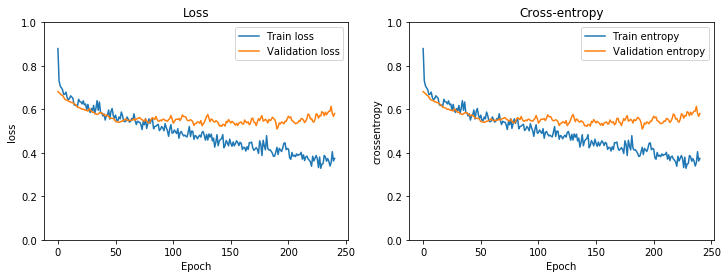

In [231]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    plt.figure(figsize=(12,4))
    plt.subplot(121)
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.plot(hist['epoch'], hist['loss'], label='Train loss')
    plt.plot(hist['epoch'], hist['val_loss'], label = 'Validation loss')
    plt.ylim([0,1])
    plt.legend()
    plt.title('Loss')
    
    
    plt.subplot(122)
    plt.xlabel('Epoch')
    plt.ylabel('crossentropy')
    plt.plot(hist['epoch'], hist['binary_crossentropy'], label='Train entropy')
    plt.plot(hist['epoch'], hist['val_binary_crossentropy'], label = 'Validation entropy')
    plt.ylim([0,1])
    plt.legend()
    plt.title('Cross-entropy')
    
    plt.savefig('loss.png')
    plt.show()
    

plot_history(history)

# Test window

In [369]:
from rdkit.Chem import Draw
from IPython.display import Image
def test_cns(smile_str):
    ## the input should be a string of SMILES.
    # smile_str = # glu:'C(C1C(C(C(C(O1)O)O)O)O)O' #'O=C=O' #'Nc1ccccc1'# 'NC(CC1=CC=CC=C1)C' Amphetamine
    mol = Chem.MolFromSmiles(smile_str)
    # Draw.MolToImage(mol)
    eins = descriptors_map(mol) # ndarray
    #
    normed_eins = normlize(eins)
    normed_eins = normed_eins.drop(labels=['num radical etron'])
    normed_eins = np.array(list(normed_eins))
    normed_eins = normed_eins.reshape(1,44)
    normed_eins.shape
    return new_model.predict(normed_eins)

In [370]:
smi_str =  'O=C(C)Oc1ccccc1C(=O)O' #Asprin # 'Cc1ccc(cc1Nc2nccc(n2)c3cccnc3)NC(=O)c4ccc(cc4)CN5CCN(CC5)C'  #Glivec  # 'NCCc1cc(O)c(O)cc1' #dopamine
test_cns(smi_str) 

array([[0.37488696]], dtype=float32)

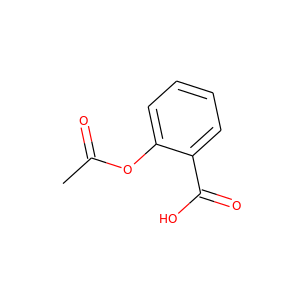

In [371]:
Draw.MolToImage(Chem.MolFromSmiles(smi_str))

# Confusion map and ROC curve

1. calculate True Positive/ Negative; False Positive/ Negative

2. plot, plt maybe

In [232]:
# (normed_data) is DataFrame; so as normed_labels
# TP, TN; FP, FN


#new_model = model
predict = new_model.predict(normed_data)    # predict is ndarray
print(predict.shape)
print(normed_label.shape)
predict_value  = predict.reshape(normed_label.shape)

(665, 1)
(665, 1)


In [205]:
def calc_confusion_matrix(model, normed_all, label_all, cutoff):
    # cutoff may leads to ROC curve;
    predict = model.predict(normed_all)
    predict_value  = predict.reshape(label_all.shape)
                                #     0:  1:
    conf_mat = np.zeros((2,2))  # 0: [FP,TP];
                                # 1: [TN,FN]  
    
    for i in range(len(predict_value)):
        p = predict_value[i][0]
        cns = float(label_all.iloc[i])
        if (p >= cutoff) & (cns >= cutoff):
            conf_mat[0,1] += 1    # true positive
        elif (p >= cutoff) & (cns < cutoff):
            conf_mat[0,0] += 1    # false positive
        elif (p < cutoff) & (cns >= cutoff):
            conf_mat[1,1] += 1    # false negative
        elif (p < cutoff) & (cns < cutoff):
            conf_mat[1,0] += 1    # true negative
        else:
            print('error appear at # ', i)
    # TPR = TP/(TP + FN)
    TPR = conf_mat[0,1]/(conf_mat[0,1] + conf_mat[1,1])
    # FPR = FP/(FP + TN)
    FPR = conf_mat[0,0]/(conf_mat[0,0] + conf_mat[1,0])
    
    accu = (conf_mat[0,1] + conf_mat[1,0])/663
    return conf_mat, TPR, FPR, accu

In [252]:
conf_mat, TPR, FPR, ACCU = calc_confusion_matrix(new_model, normed_data, normed_label, 0.43)
print(TPR, FPR, ACCU)

0.8695652173913043 0.1448087431693989 0.8642533936651584


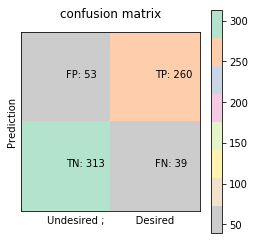

In [236]:
def plot_conf_mat(conf_mat):
    plt.matshow(conf_mat,cmap=plt.cm.Pastel2_r)
    plt.colorbar()
    plt.xlabel('Undesired ;          Desired'), plt.ylabel('Prediction')
    plt.xticks([]), plt.yticks([])
    plt.annotate('TN: '+str(int(conf_mat[1,0])),([0,1])), plt.annotate('FN: '+str(int(conf_mat[1,1])),([1,1]))
    plt.annotate('TP: '+str(int(conf_mat[0,1])),([1,0])), plt.annotate('FP: '+str(int(conf_mat[0,0])),([0,0]))
    plt.title('confusion matrix')
    plt.savefig('confsusion_matrix.png')
plot_conf_mat(conf_mat)    

# ROC curve

In [238]:
cutoffs = np.linspace(1e-10,1,50)
tpr = np.zeros(len(cutoffs))
fpr = np.zeros(len(cutoffs))
accus = np.zeros(len(cutoffs))
for i in range(len(cutoffs)):
    conf_mat, TPR, FPR, accu = calc_confusion_matrix(new_model, normed_data, normed_label, cutoffs[i])
    tpr[i], fpr[i], accus[i] = TPR, FPR, accu

max accus:  0.8627450980392157


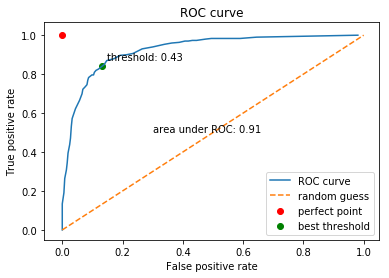

In [239]:
roc_s =  - np.trapz(tpr, fpr)
plt.plot(fpr, tpr,label='ROC curve')
plt.plot([0,1],[0,1],'--',label='random guess')  # diagonal lines
plt.scatter([0],[1], c ='r',label='perfect point')  # ideal classifier
plt.scatter(fpr[23],tpr[23], c ='green',label='best threshold')

plt.xlabel('False positive rate'), plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.annotate('area under ROC: '+str(round(roc_s, 2)), (.3, .5) )
ii = np.argmax(accus)
print('max accus: ', accus[ii])
plt.annotate('threshold: '+str(round(cutoffs[ii], 2)), (fpr[ii],tpr[ii]) )
plt.legend()
plt.savefig('roc_curve.png')
plt.show()

# False Negative & False Positive

statement about the order of drugs,

start from the original dataset: pMPO.pkl; the data goes by Name A to Z; False then True

we rank it according to name A to Z;

and pop [CNS, Drug, SMILES] into datasetB,

the we sample: train_data =  datasetB(0.8, randomstate=0) 
                test_dataset  = datasetB.drop(train_dataset.index)
             then train_data goes through Chem.MolfromSMILES; then descriptors map; then DataFrame; then 
             normalize; into "normed_train_data"
             
we then pd.concat(normed_train_data, normed_test_data) => normed_data;;; normed_label

In [253]:
datasetC = pd.concat((train_dataset, test_dataset),axis=0)
def find_false_drug(model, normed_all, label_all, cutoff, datasetC):
    # cutoff may leads to ROC curve;
    predict = model.predict(normed_all)
    predict_value  = predict.reshape(label_all.shape) 
    
    conf_mat, TPR, FPR, ACCU = calc_confusion_matrix(model, normed_all, label_all, cutoff)
    
    #false_positive = np.zeros((conf_mat[0,0],2))
    #false_negative = np.zeros((conf_mat[1,1],2))
    false_positive = []
    false_negative = []
    
    for i in range(len(predict_value)):
        p = predict_value[i][0]
        cns0 = float(label_all.iloc[i])
        cns= datasetC.iloc[i,0]
        if cns0 != cns: print('cns not the same at: ',i)  # to check if the two dataframes are same order
        name = datasetC.iloc[i,1]
        smiles = datasetC.iloc[i,2]
        if (p >= cutoff) & (cns < cutoff):
            false_positive.append([i,p,name,cns,smiles])   # false positive
        elif (p < cutoff) & (cns >= cutoff):
            false_negative.append([i,p,name,cns,smiles]) # false negative
            
    if len(false_positive) != conf_mat[0,0]:
        print('false-positive wrong')
        return 0
    if len(false_negative) != conf_mat[1,1]:
        print('false-negative wrong')
        return 1
    
    
    return false_positive, false_negative  # data type list: index, nn-score, name, cns, smile

false_positive, false_negative  = find_false_drug(new_model, normed_data, normed_label, 0.43,datasetC)

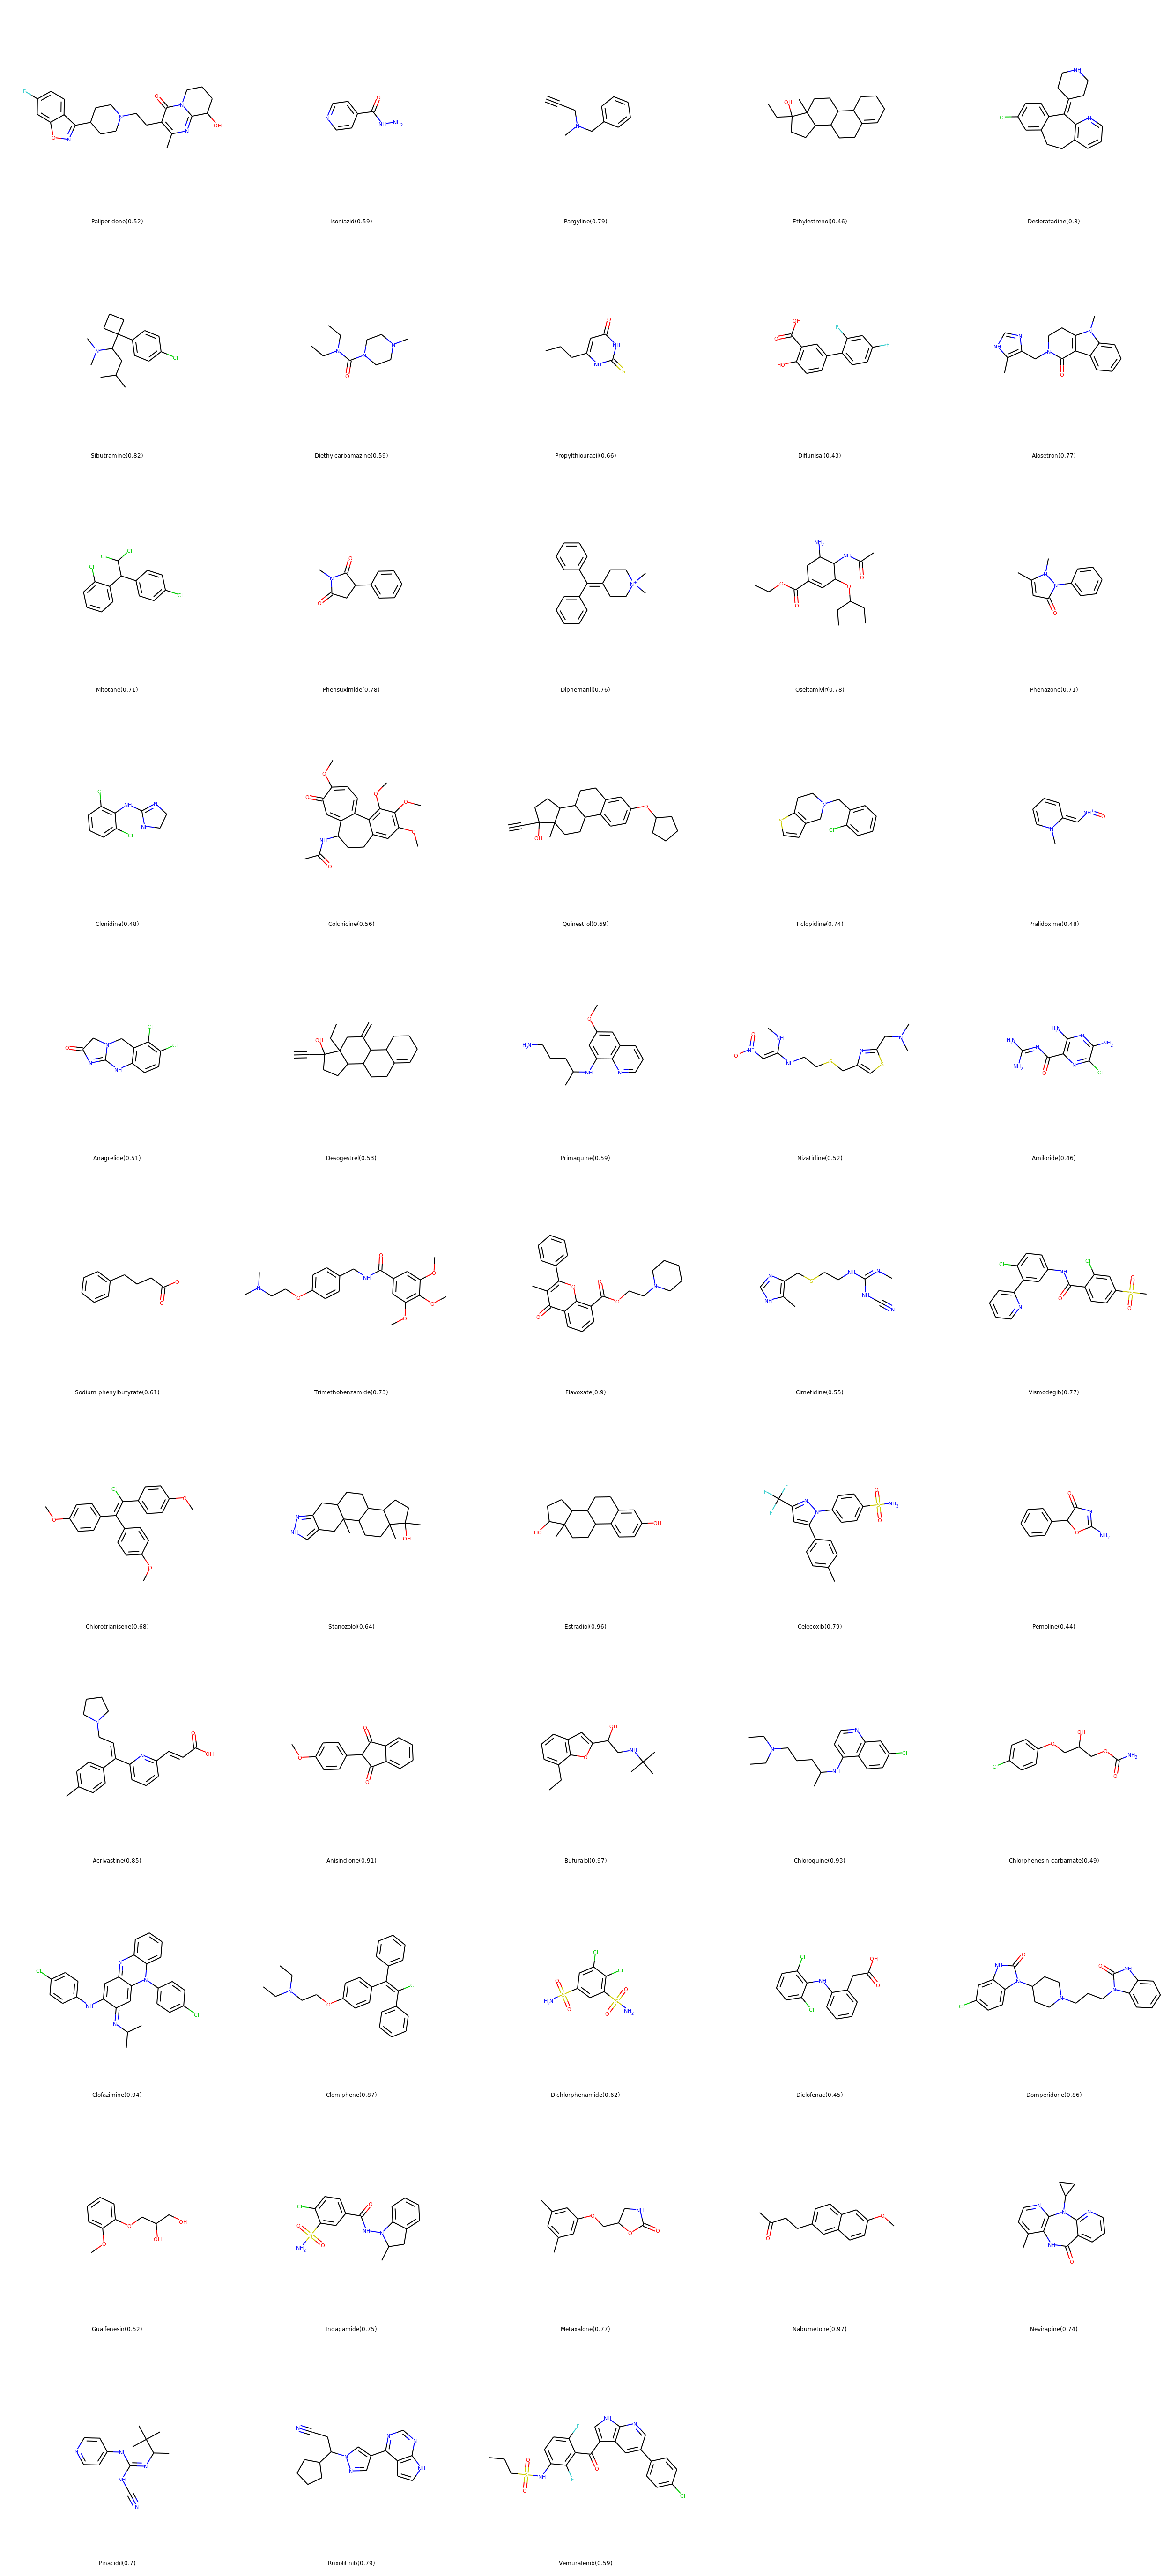

In [313]:
# Draw the drugs
fp_mols = list(map(lambda x: Chem.MolFromSmiles(x[4]), false_positive))
fp_score = list(map(lambda x: x[1], false_positive))
fp_legend = list(map(lambda x: x[2]+'('+str(round(x[1],2))+')', false_positive))
Draw.MolsToGridImage(fp_mols, molsPerRow=5, subImgSize=(500,500) , legends=fp_legend)

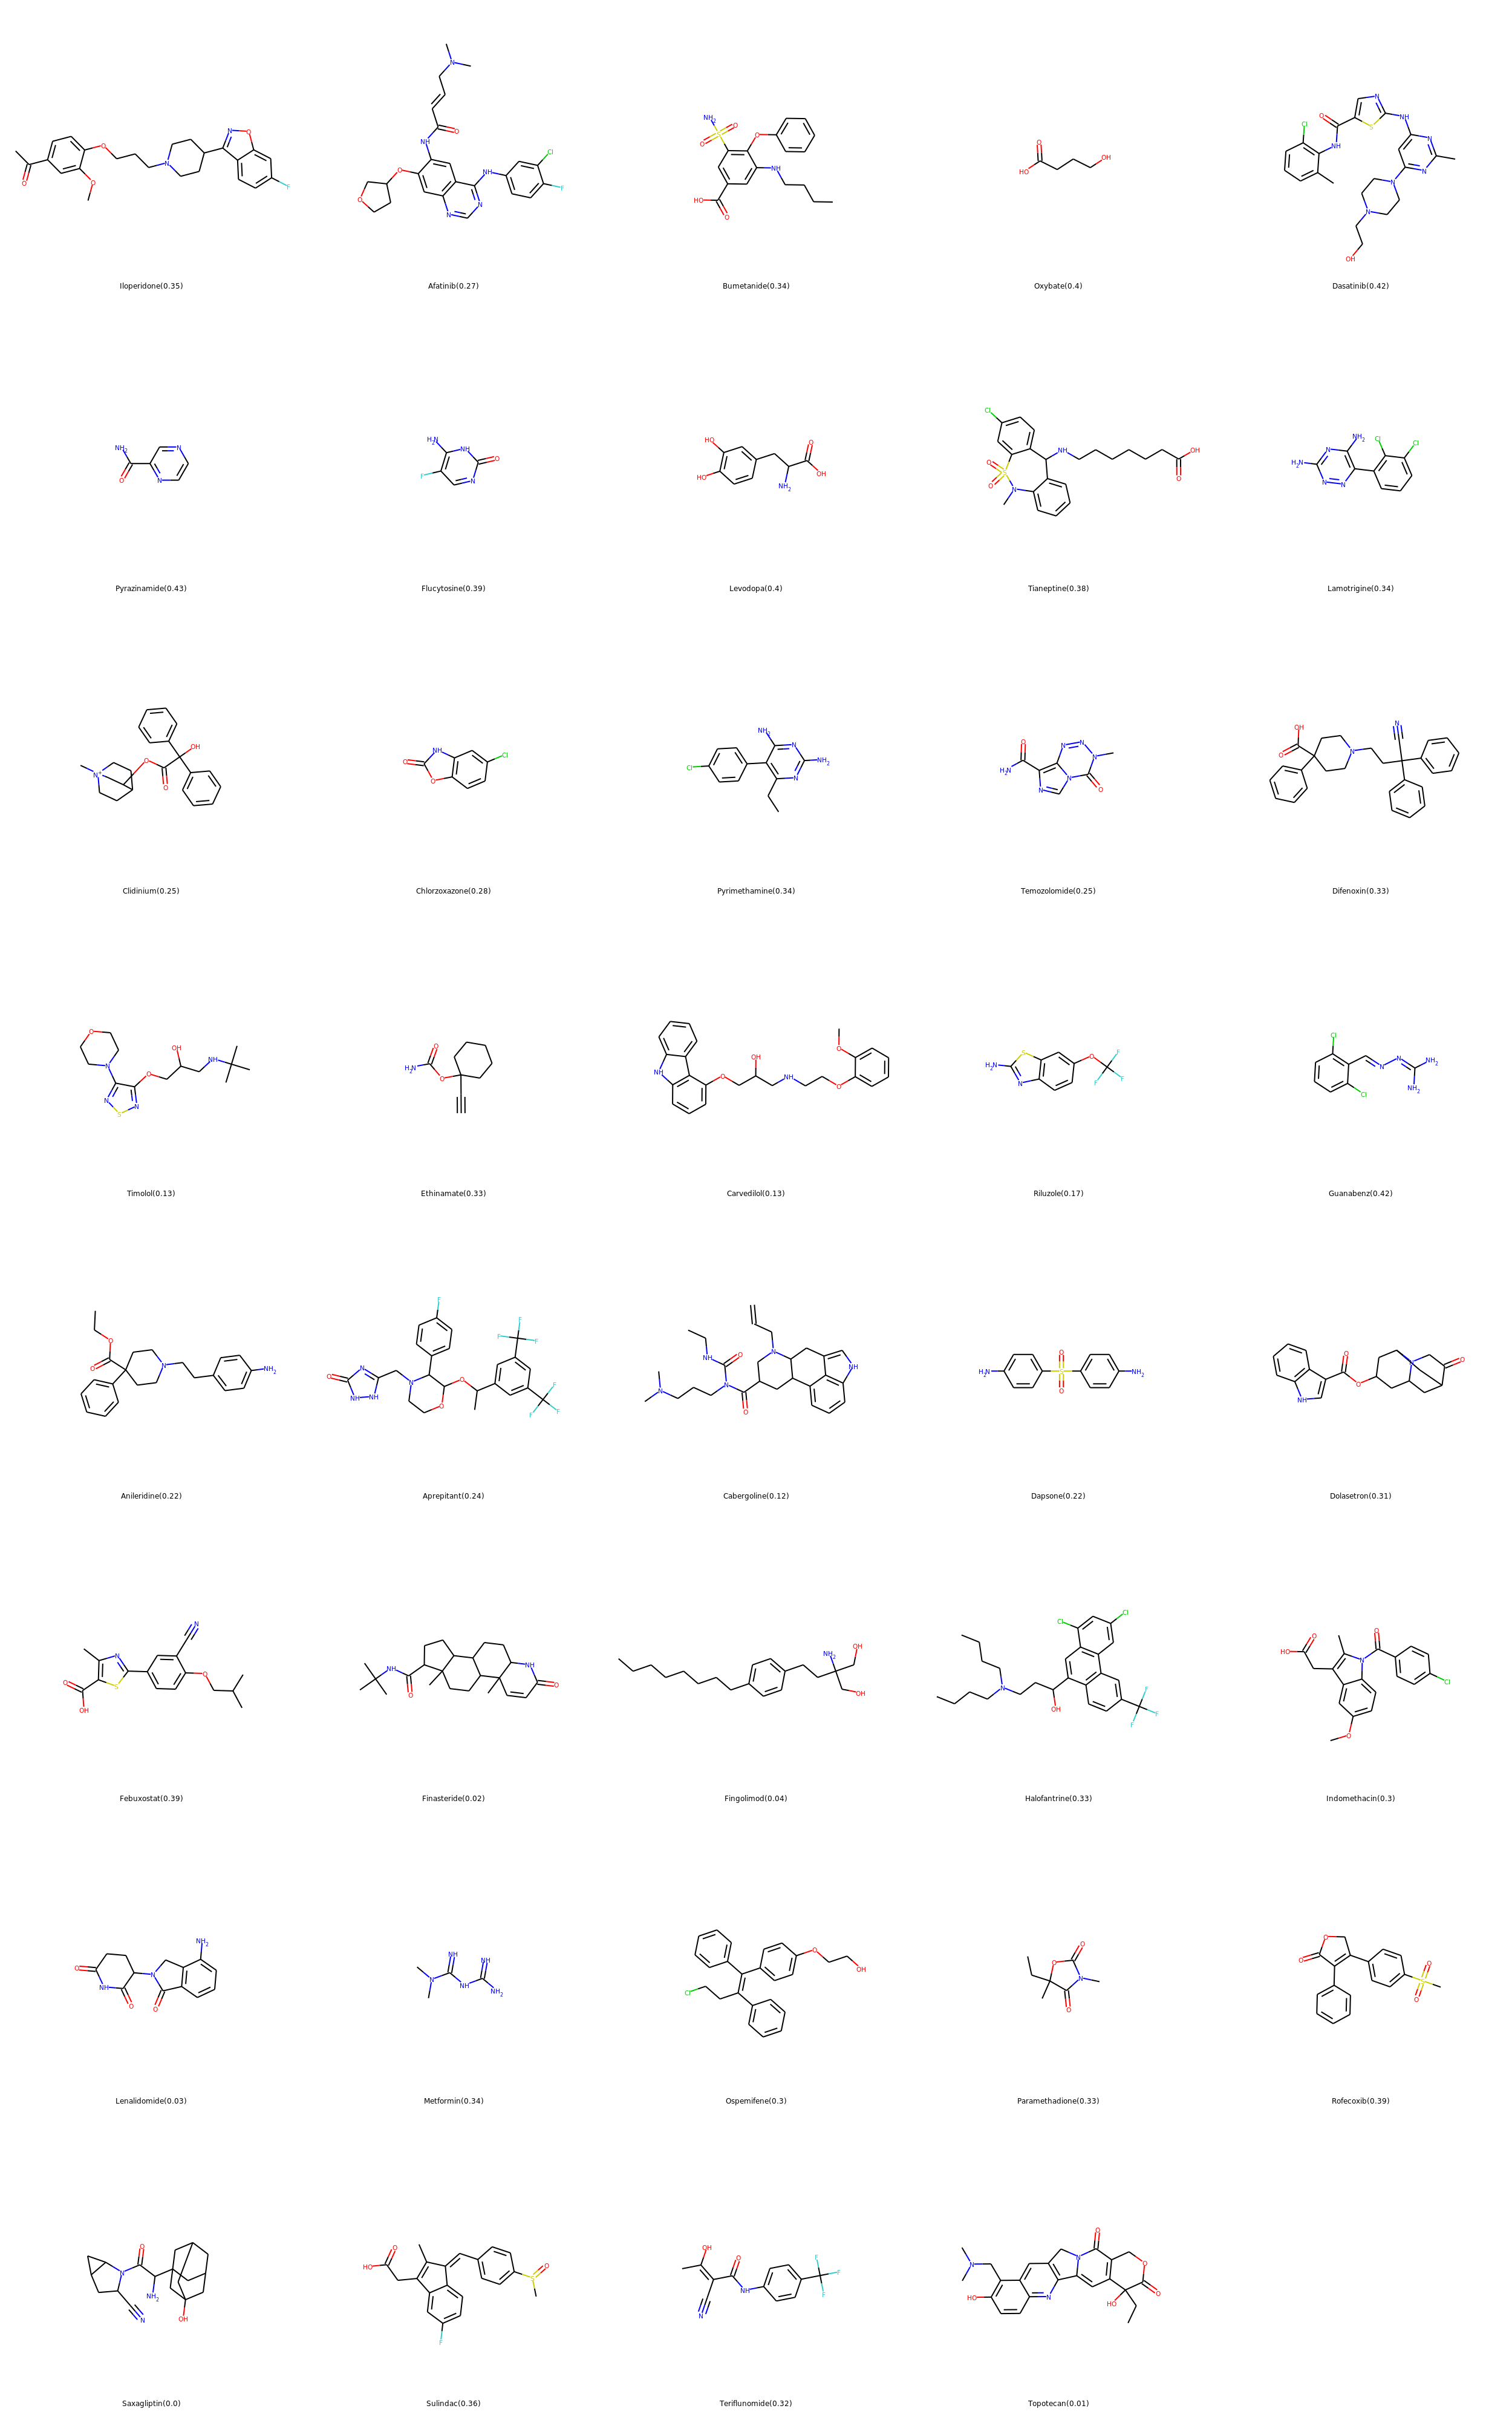

In [363]:
# Draw the drugs
fn_mols = list(map(lambda x: Chem.MolFromSmiles(x[4]), false_negative))
fn_score = list(map(lambda x: x[1], false_negative))
fn_legend = list(map(lambda x: x[2]+'('+str(round(x[1],2))+')', false_negative))
Draw.MolsToGridImage(fn_mols, molsPerRow=5, subImgSize=(500,500) , legends=fn_legend)

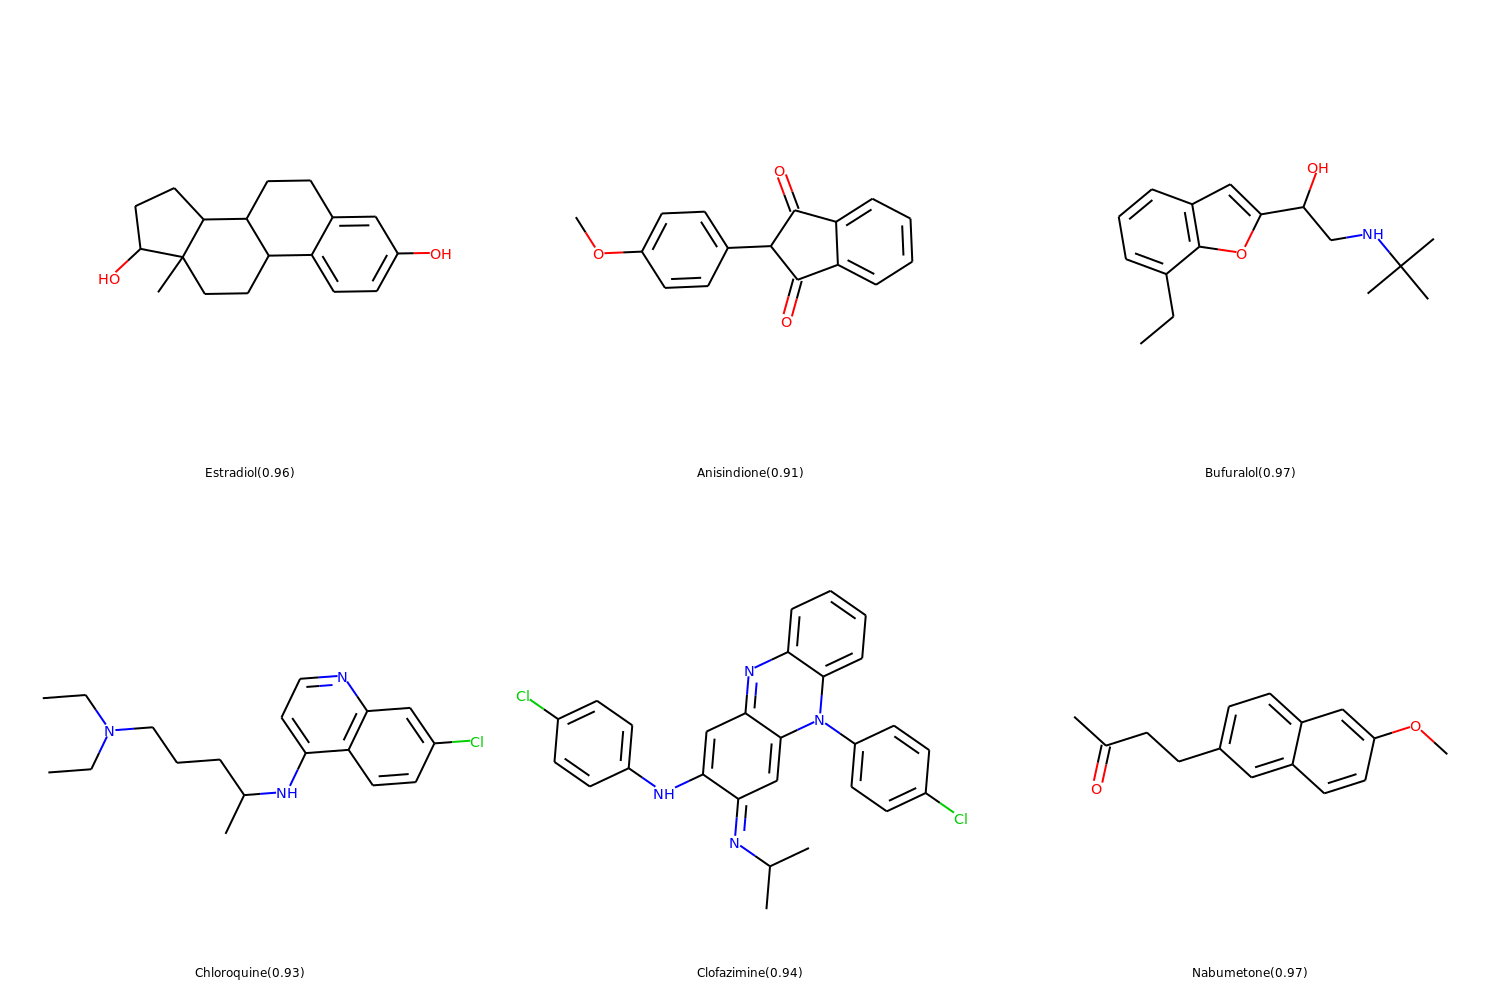

In [358]:

fp_most = np.argwhere(np.array(fp_score) > 0.9)
fp_most = fp_most.reshape(len(fp_most))
fpm_mols = list(map(lambda x: Chem.MolFromSmiles(false_positive[x][4]) , fp_most))
fpm_legend = list(map(lambda x: false_positive[x][2]+'('+str(round(false_positive[x][1],2))+')', fp_most))
Draw.MolsToGridImage(fpm_mols, molsPerRow=3, subImgSize=(500,500) , legends=fpm_legend)

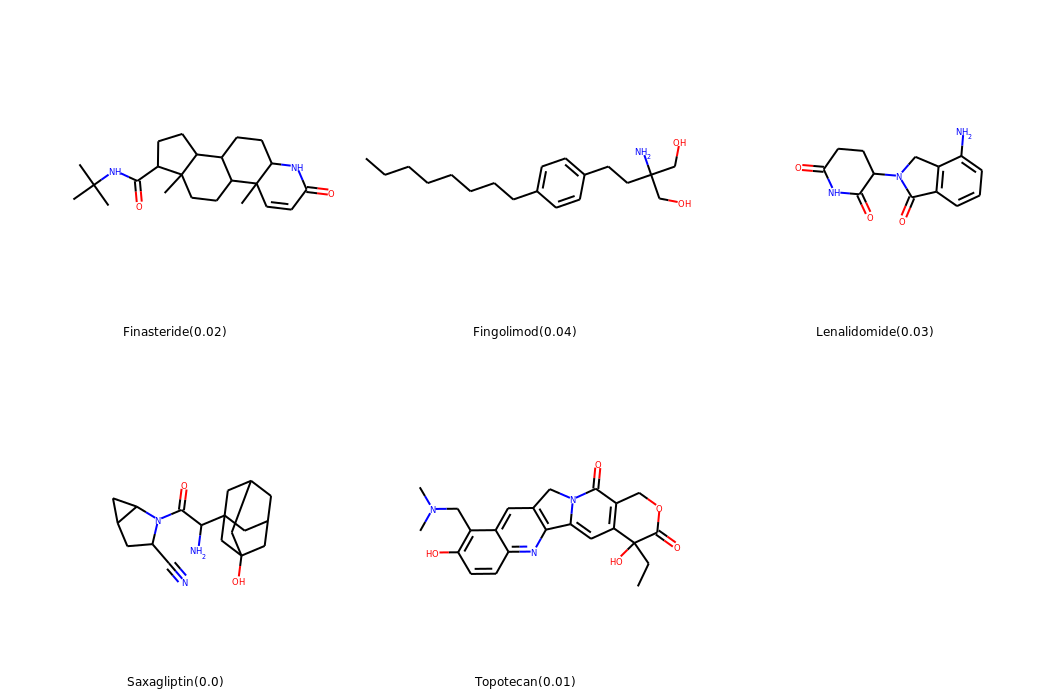

In [387]:
#plt.scatter(range(len(fn_score)), fn_score)
fn_most = np.argwhere(np.array(fn_score) < 0.1)

fn_most = fn_most.reshape(len(fn_most))
fnm_mols = list(map(lambda x: Chem.MolFromSmiles(false_negative[x][4]) , fn_most))
fnm_legend = list(map(lambda x: false_negative[x][2]+'('+str(round(false_negative[x][1],2))+')', fn_most))
Draw.MolsToGridImage(fnm_mols, molsPerRow=3, subImgSize=(350,350), legends=fnm_legend)
#img.save('test.png')

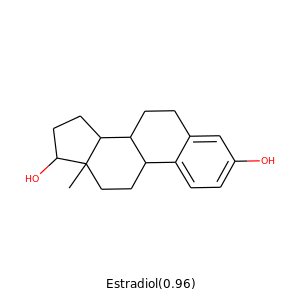

In [330]:
idd = 32
Draw.MolToImage(fp_mols[idd],legend=fp_legend[idd])

# Getting Help
## installation of the softwares, based on Linux system.
Our algorithm is developed using Python 3.7, which is a common platform for software development, one can find it easily on internet. Commands to installation are listed below:

$ conda create -n py3 python=3.7

$ conda install tensorflow

$ conda install numpy

$ conda install matplotlib

$ conda install pandas 

$ conda install -c conda-forge rdkit

$ conda install jupyter

After all the installation, run this algorithm using jupyter-notebook:

$ conda source activate py3

$ jupyter-notebook             \# this command will re-direct you from Terminal to your default web-brouser.

In [388]:
!pwd

/home/yyg/Documents/CNS-drug/cns_initio/backup
